In [1]:
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers import default_data_collator
from transformers import Wav2Vec2FeatureExtractor, HubertForSequenceClassification
import torch
import torch.nn as nn
from datasets import Dataset, Audio, Value, Features,load_dataset,ClassLabel
from transformers import Wav2Vec2Processor
from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np
from transformers import AdamW,get_scheduler
from datasets import load_metric
from tqdm.auto import tqdm
import os
from torch.utils.data import DataLoader
from datasets import load_metric


def featurize(batch):
#     audio_arrays = [batch['audio'][i]['array'] for i in range(len(batch))]
    audio_arrays = [batch['audio'][i]['array'] for i in range(len(batch['id']))]
#     print(len(audio_arrays))
    inputs = feature_extractor(
        audio_arrays, 
        sampling_rate=16_000, 
        max_length=int(16_000 * 10),  # 10s
        truncation=True, 
        padding='max_length',
    )
    return inputs



weighted_sum = False
checkpoint = "facebook/hubert-base-ls960"
# checkpoint = "facebook/wav2vec2-large-lv60"

x = [str(i) for i in range(0,100,1)]
features = Features(
    {
        "id": Value("string"),
        "speaker_id": Value("string"), 
        'path': Value('string'),
        "audio": Audio(sampling_rate=16000),
        "label": ClassLabel(num_classes=100,names=x,names_file=None,id=None)
    }
)


dataset = load_dataset('csv', 
                       data_files={'test':'test_100.csv'},
                       features=features)
dataset = dataset.map(remove_columns=(['path','speaker_id']),num_proc=24)
dataset = dataset.sort("label")
# sampling_rate = dataset.features["audio"].sampling_rate
if 'base' in checkpoint and not weighted_sum:
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(checkpoint,return_attention_mask=False)
else:
    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(checkpoint,return_attention_mask=True)


lengths = []
for i in range(len(dataset['test']['id'])):
    length = len(dataset['test']['audio'][i]['array'])
    lengths.append(length/16000)
    
with open('test_lengths.txt', 'w') as f:
    for line in lengths:
        f.write(f"{line}\n")

dataset = dataset.map(featurize, remove_columns='audio',batched=True,num_proc=20,batch_size=1)

# dataset = dataset.rename_column('id','label_ids')

if 'base' in checkpoint and not weighted_sum:
    dataset.set_format("torch",columns=["id","input_values", "label"])
else:
    dataset.set_format("torch",columns=["id","input_values", "attention_mask", "label"])

/storage/home/hcocice1/vprakash40/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-27 16:51:02.174991: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Using custom data configuration default-a5a36436e0efa59f
Found cached dataset csv (/storage/home/hcocice1/vprakash40/.cache/huggingface/datasets/csv/default-a5a36436e0efa59f/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)
100%|██████████| 1/1 [00:00<00:00, 372.07it/s]
Loading cached processed dataset at /storage/home/hcocice1/vprakash40/.cache/huggingface/datasets/csv/default-a5a36436e0efa59f/0.0.0/6b34fb

### Model

In [2]:
class CustomBaseSID(nn.Module):
    def __init__(self,checkpoint,num_labels,inter_layer_num,attend):
        
        ### attend is a boolean
        super(CustomBaseSID, self).__init__()
#         self.hubert = HubertForSequenceClassification.from_pretrained("superb/hubert-base-superb-sid")
        self.model =AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=attend,output_hidden_states=True))
        self.num_labels = num_labels
        self.attend_mask = attend
        ### New layers:
        self.linear1 = nn.Linear(768, 1024)
        self.linear2 = nn.Linear(1024, num_labels)
        
        ### Intermediate Layer Number
        self.layer_num = inter_layer_num

    def forward(self, input_values=None, attention_mask=None,labels=None):
        if(self.attend_mask):
            outputs = self.model(input_values=input_values, attention_mask=attention_mask)
        else:
            outputs = self.model(input_values=input_values, attention_mask=None)
        feature = outputs.hidden_states[self.layer_num-1]
        agg_vec_list = []
        for i in range(len(feature)):
            if(attention_mask==None):
                length = len(feature[i])
            
            else:
                if torch.nonzero(attention_mask[i] < 0, as_tuple=False).size(0) == 0:
                    length = len(feature[i])
                else:
                    length = torch.nonzero(attention_mask[i] < 0, as_tuple=False)[0] + 1
            agg_vec=torch.mean(feature[i][:length], dim=0)
            agg_vec_list.append(agg_vec)
        mean = torch.stack(agg_vec_list)
        # sequence_output has the following shape: (batch_size, sequence_length, 768)
        linear1_output = self.linear1(mean) ## extract the 1st token's embeddings
        logits = self.linear2(linear1_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return SequenceClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)


In [3]:
def freeze_layers_transformer(model_ft,keywords,inter_layer,encoder_mode=True):
    ct = 0
    for child in model_ft.children():
        for name,param in child.named_parameters():
            if(encoder_mode):
                if 'encoder' in name and str(ct) in name:
                    ct += 1
                    if ct < inter_layer:
                        param.requires_grad = False
                    
            for word in keywords:         
                if word in name:
                    param.requires_grad = False
                            
    return model_ft

In [4]:
dataset

DatasetDict({
    test: Dataset({
        features: ['id', 'label', 'input_values'],
        num_rows: 632
    })
})

In [5]:
def load_model(checkpoint, num_labels, inter_layer, model_dirpath, device):
    dirpath = model_dirpath + str(inter_layer)+'/'
    PATH = dirpath+str(4)+'.pt'
    if 'base' in checkpoint:
        attend = False
#     model_name = "model_ft_" + pretrained_model_name + str(inter_layer)
    model_ft = CustomBaseSID(checkpoint=checkpoint,num_labels=100,inter_layer_num=inter_layer,attend=attend)
    model_ft.load_state_dict(torch.load(PATH, map_location=device))

    return model_ft

In [6]:
metric_name="accuracy"
metric = load_metric(metric_name)
test_dataloader = DataLoader(dataset["test"], batch_size=1, collate_fn=default_data_collator)

/scratch/470806.sched-coc-ice.pace.gatech.edu/ipykernel_257801/1426700558.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric(metric_name)


In [7]:
# keys = list(dataset['test'].features.keys())
keys = list(dataset['test']['id'])
test_dict = dict.fromkeys(keys)

In [8]:
list(test_dict.keys())[0]

'id10001-Y8hIVOBuels-00001'

In [9]:
def evaluate(test_dataloader,model_ft):
    test_dict = dict.fromkeys(list(dataset['test']['id']))
    keys = list(test_dict.keys())
    
    for i,batch in enumerate(test_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model_ft(**batch)
        logits = outputs.logits
        sm = torch.nn.Softmax(dim=1)
        probabilities = sm(logits)
        test_dict[keys[i]] = dict.fromkeys(['labels','probabilities','predictions'])
        test_dict[keys[i]]['labels'] = batch['labels'].detach().numpy()
        test_dict[keys[i]]['probabilities'] = probabilities[0].detach().numpy()
        predictions = torch.argmax(logits, dim=-1)
        test_dict[keys[i]]['predictions'] = predictions[0].detach().numpy()
        metric.add_batch(predictions=predictions, references=batch["labels"])
    accuracy = metric.compute()
    return test_dict,accuracy

## hubertbase 12 layer

In [10]:
checkpoint_hubertbase = 'facebook/hubert-base-ls960'
model_dirpath = "/storage/home/hcocice1/vprakash40/statmlfinal/hubert-base/"
device = "cpu"
model_ft_hubertbase_12 = load_model(checkpoint_hubertbase, 100, 12, model_dirpath, device)

hubertbase_12,hubertbase_12_accuracy = evaluate(test_dataloader,model_ft_hubertbase_12)

## hubertbase 9 layer

In [11]:
checkpoint_hubertbase = 'facebook/hubert-base-ls960'
model_dirpath = "/storage/home/hcocice1/vprakash40/statmlfinal/hubert-base/"
device = "cpu"
model_ft_hubertbase_9 = load_model(checkpoint_hubertbase, 100, 9, model_dirpath, device)

hubertbase_9,hubertbase_9_accuracy = evaluate(test_dataloader,model_ft_hubertbase_9)

## hubertbase 6 layer

In [12]:
checkpoint_hubertbase = 'facebook/hubert-base-ls960'
model_dirpath = "/storage/home/hcocice1/vprakash40/statmlfinal/hubert-base/"
device = "cpu"
model_ft_hubertbase_6 = load_model(checkpoint_hubertbase, 100, 6, model_dirpath, device)

hubertbase_6,hubertbase_6_accuracy = evaluate(test_dataloader,model_ft_hubertbase_6)

## hubertbase results

### 12 layer

In [13]:
hubertbase_12

{'id10001-Y8hIVOBuels-00001': {'labels': array([0]),
  'probabilities': array([8.81197691e-01, 1.01666586e-07, 3.12043034e-04, 4.54870024e-05,
         5.22514712e-03, 5.06509386e-04, 2.84728162e-06, 4.79955361e-07,
         3.92690953e-03, 2.14820015e-04, 5.42870157e-06, 1.71008518e-09,
         2.52510927e-05, 1.81560245e-06, 1.92368934e-05, 4.26610484e-07,
         7.45218813e-06, 1.04255412e-06, 9.39381664e-07, 9.57552675e-06,
         4.81551775e-04, 1.51764947e-08, 8.25857744e-04, 2.51432448e-05,
         4.26714024e-08, 4.70644591e-04, 1.52735538e-05, 5.18992067e-07,
         1.38575451e-05, 2.82166388e-06, 1.54440022e-05, 2.91082074e-07,
         7.33272145e-06, 2.11644775e-07, 2.14335218e-04, 6.93868458e-07,
         2.81364861e-04, 1.01774029e-04, 8.43309181e-07, 2.74256450e-07,
         2.81587607e-08, 1.16080046e-04, 6.91260524e-08, 4.83386486e-08,
         1.72022414e-08, 1.03703130e-07, 2.39514202e-06, 1.75304464e-07,
         1.37137510e-08, 2.19551894e-05, 2.46827876e-0

In [14]:
hubertbase_12_accuracy

{'accuracy': 0.9525316455696202}

### 9 layer

In [15]:
hubertbase_9

{'id10001-Y8hIVOBuels-00001': {'labels': array([0]),
  'probabilities': array([6.41827703e-01, 5.03011452e-11, 3.99937107e-06, 1.67126767e-04,
         3.23115103e-02, 4.08405249e-05, 9.96519489e-09, 3.46159140e-07,
         3.88064957e-03, 1.09123175e-04, 7.37597134e-07, 2.14453390e-12,
         2.70936607e-06, 4.10373929e-10, 9.40257383e-09, 4.50684379e-10,
         2.62218469e-09, 3.53745904e-08, 8.73037425e-06, 2.76032661e-05,
         5.07634941e-05, 1.05626841e-09, 9.77173404e-05, 1.13264342e-07,
         3.01929350e-11, 1.75468926e-03, 4.56228794e-04, 4.52006876e-09,
         4.45687469e-08, 2.72827333e-06, 1.75814072e-04, 4.20410262e-10,
         1.78296389e-09, 1.02390763e-08, 3.47431973e-02, 1.75150228e-09,
         5.92688448e-04, 2.49732675e-05, 2.19644978e-08, 1.49323895e-08,
         4.52061000e-10, 1.30666490e-06, 3.71237654e-08, 4.13682699e-07,
         1.01974607e-09, 1.90482492e-08, 4.85468696e-08, 1.09540758e-06,
         2.16576715e-10, 8.19835041e-05, 4.55282759e-0

In [16]:
hubertbase_9_accuracy

{'accuracy': 0.9050632911392406}

### 6 layer

In [17]:
hubertbase_6

{'id10001-Y8hIVOBuels-00001': {'labels': array([0]),
  'probabilities': array([6.32136226e-01, 7.82466927e-08, 4.98054287e-05, 1.48857405e-04,
         3.16102766e-02, 4.57268561e-06, 5.11750748e-08, 1.18933601e-08,
         1.13444345e-03, 4.31435319e-06, 3.16158946e-07, 4.85926273e-12,
         2.93699486e-06, 8.45497505e-10, 5.33603961e-09, 1.26588455e-08,
         3.89550650e-07, 1.02949025e-05, 7.04300192e-07, 1.85385137e-03,
         6.46272022e-03, 3.75057230e-09, 1.65855570e-04, 4.32112435e-09,
         1.86660114e-11, 1.86034667e-04, 9.85444430e-03, 7.33528482e-09,
         1.20066559e-07, 1.89862149e-07, 3.82585204e-05, 1.40590748e-08,
         3.39696768e-08, 3.50491263e-08, 5.39696543e-04, 5.40940412e-08,
         2.95020300e-06, 2.66722992e-07, 2.08814396e-10, 1.09810770e-07,
         5.06572384e-09, 8.08667482e-06, 2.98932723e-09, 9.58837870e-11,
         6.16797593e-07, 8.74515607e-08, 2.93964000e-08, 8.94206309e-08,
         6.16715512e-10, 9.57675525e-07, 4.45610283e-0

In [18]:
hubertbase_6_accuracy

{'accuracy': 0.8924050632911392}

## hubertbase ensemble

In [19]:
num_models = 3
ensemble_test_dict = hubertbase_6.copy()
key = 'id10001-Y8hIVOBuels-00001'

for key in hubertbase_6.keys():
    mean_prob = np.asarray([sum(x) for x in zip(hubertbase_6[key]['probabilities'], hubertbase_9[key]['probabilities'], hubertbase_12[key]['probabilities'])])/num_models
    ensemble_test_dict[key]['probabilities'] = mean_prob
    ensemble_test_dict[key]['predictions'] = np.argmax(mean_prob)
    metric.add(prediction=ensemble_test_dict[key]['predictions'], reference = ensemble_test_dict[key]['labels'])

accuracy = metric.compute()

In [20]:
accuracy

{'accuracy': 0.9731012658227848}

## Top 3 Probabilities

In [21]:
def get_top3_accuracy(out_dict):
    test_length = 632
    correct_count=0
    for key in out_dict.keys():
        val=out_dict[key]
        out_dict[key]['top3'] = []
        top_3_out_dict=sorted(zip(val['probabilities'],range(len(val['probabilities']))), reverse = True)[:3]
        out_dict[key]['top3'] = top_3_out_dict
    for key in out_dict.keys():
        top3_labels = [x[1] for x in out_dict[key]['top3']]
        label = out_dict[key]['labels'][0]
        if (label in top3_labels):
            correct_count+=1
            
    return out_dict,correct_count/test_length


hubertbase_12,top3_hubertbase_12_acc = get_top3_accuracy(hubertbase_12)
hubertbase_9,top3_hubertbase_9_acc = get_top3_accuracy(hubertbase_9)
hubertbase_6,top3_hubertbase_6_acc = get_top3_accuracy(hubertbase_6)




In [22]:
print(top3_hubertbase_12_acc,top3_hubertbase_9_acc,top3_hubertbase_6_acc)

0.995253164556962 0.9810126582278481 0.9984177215189873


In [23]:
dataset['test']

Dataset({
    features: ['id', 'label', 'input_values'],
    num_rows: 632
})

In [24]:
lengths

[4.5600625,
 11.1200625,
 4.8400625,
 4.6800625,
 10.5600625,
 4.5200625,
 5.2800625,
 4.9600625,
 12.4800625,
 4.3200625,
 8.2000625,
 9.1200625,
 4.3600625,
 4.6800625,
 4.1200625,
 5.3200625,
 5.3600625,
 9.6400625,
 5.4000625,
 6.5200625,
 4.2000625,
 3.9600625,
 4.7600625,
 10.2800625,
 8.7200625,
 6.8400625,
 8.6800625,
 7.6800625,
 33.9600625,
 6.5200625,
 17.7600625,
 5.2400625,
 4.6400625,
 6.9600625,
 9.9200625,
 26.9200625,
 7.8800625,
 10.3200625,
 4.4800625,
 6.0000625,
 5.3200625,
 13.6800625,
 12.3600625,
 4.6800625,
 6.6800625,
 15.3600625,
 6.2800625,
 5.4800625,
 5.0800625,
 9.3600625,
 15.6400625,
 5.1200625,
 23.2800625,
 11.8400625,
 4.8000625,
 5.6400625,
 5.1600625,
 5.6400625,
 5.4000625,
 4.9600625,
 4.4000625,
 4.8000625,
 6.6800625,
 5.2000625,
 5.6400625,
 6.2000625,
 5.2800625,
 4.5200625,
 14.0000625,
 10.7200625,
 8.2800625,
 7.8800625,
 4.4000625,
 9.8800625,
 5.7600625,
 6.0800625,
 4.5600625,
 4.7600625,
 13.5600625,
 17.5600625,
 8.0000625,
 5.1200625

In [25]:
# lengths = []
# for i in range(len(dataset['test']['id'])):
#     length = len(dataset['test']['audio'][i]['array'])
#     lengths.append(length/16000)
    
# with open('test_lengths.txt', 'w') as f:
#     for line in lengths:
#         f.write(f"{line}\n")

def append_audio_lengths(out_dict):
    lengths = []
    with open('test_lengths.txt','r') as file:
        lengths = [float(line.rstrip()) for line in file]
    for length,key in zip(lengths,hubertbase_12.keys()):
        out_dict[key]['audio_length'] = length
        
    return out_dict

In [26]:
hubertbase_6 = append_audio_lengths(hubertbase_6)
hubertbase_9 = append_audio_lengths(hubertbase_9)
hubertbase_12 = append_audio_lengths(hubertbase_12)

In [27]:
hubertbase_12

{'id10001-Y8hIVOBuels-00001': {'labels': array([0]),
  'probabilities': array([8.81197691e-01, 1.01666586e-07, 3.12043034e-04, 4.54870024e-05,
         5.22514712e-03, 5.06509386e-04, 2.84728162e-06, 4.79955361e-07,
         3.92690953e-03, 2.14820015e-04, 5.42870157e-06, 1.71008518e-09,
         2.52510927e-05, 1.81560245e-06, 1.92368934e-05, 4.26610484e-07,
         7.45218813e-06, 1.04255412e-06, 9.39381664e-07, 9.57552675e-06,
         4.81551775e-04, 1.51764947e-08, 8.25857744e-04, 2.51432448e-05,
         4.26714024e-08, 4.70644591e-04, 1.52735538e-05, 5.18992067e-07,
         1.38575451e-05, 2.82166388e-06, 1.54440022e-05, 2.91082074e-07,
         7.33272145e-06, 2.11644775e-07, 2.14335218e-04, 6.93868458e-07,
         2.81364861e-04, 1.01774029e-04, 8.43309181e-07, 2.74256450e-07,
         2.81587607e-08, 1.16080046e-04, 6.91260524e-08, 4.83386486e-08,
         1.72022414e-08, 1.03703130e-07, 2.39514202e-06, 1.75304464e-07,
         1.37137510e-08, 2.19551894e-05, 2.46827876e-0

# Audio Length wise analysis

In [28]:
def get_length_acc(out_dict):
    cnta=cntb=cntc=cntd=cnte=cntf=0
    matcha=matchb=matchc=matchd=matche=matchf=0
    for key in out_dict.keys():
        if out_dict[key]['audio_length'] <= 2:
            cnta+=1
            if out_dict[key]['labels'] == out_dict[key]['predictions']:
                matcha+=1
        elif out_dict[key]['audio_length'] > 2 and out_dict[key]['audio_length'] <= 4:
            cntb+=1
            if out_dict[key]['labels'] == out_dict[key]['predictions']:
                matchb+=1
        elif out_dict[key]['audio_length'] > 4 and out_dict[key]['audio_length'] <= 6:
            cntc+=1
            if out_dict[key]['labels'] == out_dict[key]['predictions']:
                matchc+=1
        elif out_dict[key]['audio_length'] > 6 and out_dict[key]['audio_length'] <= 8:
            cntd+=1
            if out_dict[key]['labels'] == out_dict[key]['predictions']:
                matchd+=1
        elif out_dict[key]['audio_length'] > 8 and out_dict[key]['audio_length'] <= 10:
            cnte+=1
            if out_dict[key]['labels'] == out_dict[key]['predictions']:
                matche+=1
        elif out_dict[key]['audio_length'] > 10:
            cntf+=1
            if out_dict[key]['labels'] == out_dict[key]['predictions']:
                matchf+=1
#     matcha/(cnta+1) if cnta==0 else matcha/cnta
#     cntb=1 if cntb==0
#     cntc=1 if cntc==0
#     cntd=1 if cntd==0
#     cnte=1 if cnte==0
#     cntf=1 if cntf==0
        
    return matcha/(cnta+1) if cnta==0 else matcha/cnta,matchb/(cntb+1) if cntb==0 else matchb/cntb,matchc/(cntc+1) if cntc==0 else matchc/cntc,matchd/(cntd+1) if cntd==0 else matchd/cntd,matche/(cnte+1) if cnte==0 else matche/cnte,matchf/(cntf+1) if cntf==0 else matchf/cntf
        

In [29]:
acca_6,accb_6,accc_6,accd_6,acce_6,accf_6 = get_length_acc(hubertbase_6)
acca_9,accb_9,accc_9,accd_9,acce_9,accf_9 = get_length_acc(hubertbase_9)
acca_12,accb_12,accc_12,accd_12,acce_12,accf_12 = get_length_acc(hubertbase_12)
list_6 = [acca_6,accb_6,accc_6,accd_6,acce_6,accf_6]
list_9 = [acca_9,accb_9,accc_9,accd_9,acce_9,accf_9]
list_12 = [acca_12,accb_12,accc_12,accd_12,acce_12,accf_12]

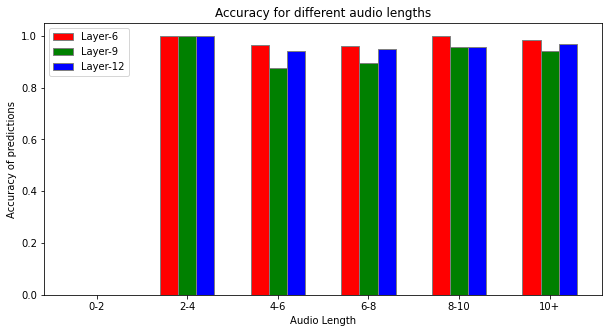

(array([0, 1, 2, 3, 4, 5]),
 [0.2, 1.2, 2.2, 3.2, 4.2, 5.2],
 [0.4, 1.4, 2.4000000000000004, 3.4000000000000004, 4.4, 5.4])

In [37]:
from matplotlib import pyplot as plt
import numpy as np

lens=['0-2', '2-4', '4-6', '6-8', '8-10', '10+']
width = 0.2
fig = plt.figure(figsize = (10, 5))

# Set position of bar on X axis
br1 = np.arange(len(list_6))
br2 = [x + width for x in br1]
br3 = [x + width for x in br2]

# creating the bar plot
plt.bar(br1, list_6, color ='r', width = width,
        edgecolor ='grey', label ='Layer-6')
plt.bar(br2, list_9, color ='g', width = width,
        edgecolor ='grey', label ='Layer-9')
plt.bar(br3, list_12, color ='b', width = width,
        edgecolor ='grey', label ='Layer-12')
 
plt.xlabel("Audio Length")
plt.ylabel("Accuracy of predictions")
plt.xticks([r + width for r in range(len(list_6))],lens)
plt.title("Accuracy for different audio lengths")
plt.legend()
plt.show()
br1,br2,br3

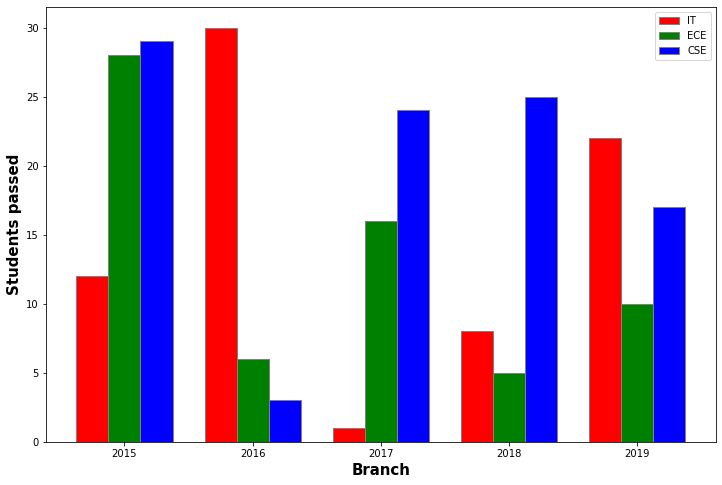

array([0, 1, 2, 3, 4])